# MASIE Ice Extent
The MASIE ice extent product is produced by the USNIC using a variety of satellite images and reports. It is an operational product that reflects the best estimate at the time and is intended for use in weather forecasting. We choose it as a good estimate of the ice fraction (grid cells with at least 15% ice cover) for a day as a supplement to the passive microwave SIC estimate. It is not appropriate for long-term trend analysis, since the source data can vary, and we do not use it for such.

# Accessing MASIE data
To get the MASIE ice extent data for each day, I look through all the dates in the validation table, check if the data for that date is already on my computer, an dif not, I download it. Only one day is missing: day 204 of 2007. For that day, I downloaded the day before and after. Since the MASIE image shows the region is 100% inside the sea ice edge both days, we just use the prior day to replace the missing image.

In [9]:
"""MASIE is an NSIDC data product that uses multiple sensors to estimate the location of the sea ice edge. It is available at
4 km resolution from 2006-present, and 1-km resolution since 2014. We can use this data for a more acurate measure of the
sea ice fraction within images. Once the file is made, it can be run in the terminal using

wget -nd --no-check-certificate --reject "index.html*" -np -e robots=off -i masie_urls.txt
"""

import pandas as pd
import numpy as np
import os

all_cases = pd.read_csv('../data/metadata/merged_validation_table.csv')
dates = pd.to_datetime([d for d in all_cases['start_date'].unique()])

filepaths = []
for d in dates:
    if d.year >= 2006:
        prefix = 'https://noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only'
        year = str(d.year)
        fname = 'masie_ice_r00_v01_{d}_4km.tif'.format(d=year + str(d.dayofyear).zfill(3))
        filepaths.append('/'.join([prefix, year, fname]))

# Record the list of MASIE filepaths
with open("../data/masie/masie_urls.txt", 'w') as file:
    for url in filepaths:
        file.write(url+'\n')

In [10]:
# Check if any of the masie files haven't been downloaded yet

need_it = []
for file in filepaths:
    local_path = '/Users/dwatkin2/Documents/research/data/masie_4km/'
    if os.path.exists(local_path + file.split('/')[-1]):
        pass
    else:
        need_it.append(file)
len(need_it)
need_it

['https://noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/2018/masie_ice_r00_v01_2018207_4km.tif',
 'https://noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/2007/masie_ice_r00_v01_2007204_4km.tif',
 'https://noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/2014/masie_ice_r00_v01_2014254_4km.tif',
 'https://noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/2015/masie_ice_r00_v01_2015222_4km.tif',
 'https://noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/2012/masie_ice_r00_v01_2012227_4km.tif']

In [11]:
# Download any MASIE images that haven't been accessed yet. Everything is placed into a noaadata.apps folder.
import os
for file in filepaths:
    local_path = '/Users/dwatkin2/Documents/research/data/masie_4km/'
    if os.path.exists(local_path + file.split('/')[-1]):
        pass
    else:
        ! wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies --no-check-certificate --auth-no-challenge=on -r --reject "index.html*" -np -e robots=off $file

--2025-03-04 16:54:15--  https://noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/2018/masie_ice_r00_v01_2018207_4km.tif
128.138.135.43data.apps.nsidc.org (noaadata.apps.nsidc.org)... 
connected. to noaadata.apps.nsidc.org (noaadata.apps.nsidc.org)|128.138.135.43|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 37800237 (36M) [image/tiff]
Saving to: ‘noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/2018/masie_ice_r00_v01_2018207_4km.tif’

noaadata.apps.nsidc 100%[===================>]  36.05M  10.9MB/s    in 3.5s    

2025-03-04 16:54:19 (10.2 MB/s) - ‘noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/2018/masie_ice_r00_v01_2018207_4km.tif’ saved [37800237/37800237]

FINISHED --2025-03-04 16:54:19--
Total wall clock time: 3.9s
Downloaded: 1 files, 36M in 3.5s (10.2 MB/s)
--2025-03-04 16:54:19--  https://noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/2007/masie_ice_r00_v01_2007204_4km.tif
Resolving noaadata.apps.nsidc.org (noaadata.apps.ns

In [12]:
# Copy the images it to the data directory
years = [y for y in os.listdir("noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/") if '.' not in y]
for year in years:
    dataloc = "noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/" + year
    files = os.listdir(dataloc)
    for f in files:
        if 'tif' in f:
            oldpath = dataloc + '/' + f
            newpath = "/Users/dwatkin2/Documents/research/data/masie_4km/" + f
            if not os.path.exists(newpath):
                ! cp $oldpath $newpath

# Interpolating to the MODIS resolution and projection
In this section, we take the MASIE image, which is polar stereographic with 60 degree true scale latitude, and we interpolate via nearest neighbors to the projection and resolution of the MODIS images. We use the MASIE landmask in the calculation, since there may be slight differences in coast positions between products. We use the `warp` function in `rasterio` to do this.

In [13]:
import rasterio as rio
import pandas as pd
import numpy as np

df = pd.read_csv('../data/metadata/merged_validation_table.csv', index_col=0, parse_dates=['start_date'])
image_loc = "/Users/dwatkin2/Documents/research/data/masie_4km/"

In [14]:
# masie landmask location
lm_image_loc = image_loc + 'landmask_r00.tif'

for row, data in df.iterrows():
    if data.satellite == 'aqua': # Only need one per day
        cn = str(row).zfill(3)
        
        region = data.region
        dx = '100km'
        datestring = data.start_date.strftime('%Y%m%d')
        
        tc_image_loc = "../data/modis/truecolor/" + '-'.join([cn, region, dx, datestring]) + ".aqua.truecolor.250m.tiff"
        ms_image_loc = image_loc + 'masie_ice_r00_v01_{y}{d}_4km.tif'.format(y=data.start_date.year,
                                                                             d=str(data.start_date.dayofyear).zfill(3))
    
        resampled_image_loc = "../data/masie/masie_ice/" + '-'.join([cn, region, dx, datestring]) + ".masie.seaice.250m.tiff"
        resampled_land_loc = "../data/masie/masie_land/" + '-'.join([cn, region, dx, datestring]) + ".masie.landmask.250m.tiff"
        if not os.path.exists(resampled_image_loc):
            if os.path.exists(ms_image_loc) & os.path.exists(tc_image_loc):
                ! rio warp $ms_image_loc $resampled_image_loc --like $tc_image_loc
            elif data.start_date == pd.to_datetime('2007-07-23'):
                ms_image_loc = image_loc + 'masie_ice_r00_v01_{y}{d}_4km.tif'.format(y=data.start_date.year,
                                                                     d=str(data.start_date.dayofyear - 1).zfill(3))
                ! rio warp $ms_image_loc $resampled_image_loc --like $tc_image_loc
            else:
                print(cn, data.start_date.year, data.start_date.dayofyear, 'not found', os.path.exists(ms_image_loc), os.path.exists(resampled_image_loc), os.path.exists(tc_image_loc))                
        if not os.path.exists(resampled_land_loc):
            if os.path.exists(lm_image_loc) & os.path.exists(tc_image_loc):    
                ! rio warp $lm_image_loc $resampled_land_loc --like $tc_image_loc
            
        else:
            pass
            # print(cn, 'done already')

# Compute land and ice fraction estimates
We estimate the land and ice fraction by pixel counting (mean of the binary images)

In [15]:
df['masie_ice_fraction'] = np.nan
df['masie_land_fraction'] = np.nan
df['modis_land_fraction'] = np.nan

for row, data in df.iterrows():

    cn = str(row).zfill(3)
    
    region = data.region
    dx = '100km'
    datestring = data.start_date.strftime('%Y%m%d')
    
    resampled_image_loc = "../data/masie/masie_ice/" + '-'.join([cn, region, dx, datestring]) + ".masie.seaice.250m.tiff"
    resampled_land_loc = "../data/masie/masie_land/" + '-'.join([cn, region, dx, datestring]) + ".masie.landmask.250m.tiff"
    modis_land_loc = "../data/modis/landmask/" + '-'.join([cn, region, dx, datestring]) + ".aqua.landmask.250m.tiff"
    
    if os.path.exists(resampled_image_loc) & os.path.exists(resampled_land_loc):
        with rio.open(resampled_image_loc) as masie_ice:
            with rio.open(resampled_land_loc) as masie_land:
                lf = np.mean(masie_land.read() > 1)
                df.loc[row, 'masie_land_fraction'] = np.round(lf, 2)
                sif = np.mean(masie_ice.read() > 0)
                if lf <= 0.95: 
                    sif = sif/(1-lf)
                    df.loc[row, 'masie_ice_fraction'] = np.round(sif, 2)
            with rio.open(modis_land_loc) as modis_land:
                lf = np.mean(modis_land.read() > 1)
                df.loc[row, 'modis_land_fraction'] = np.round(lf, 2)

    else:
        print('MASIE image', os.path.exists(resampled_image_loc), 'MASIE land', os.path.exists(resampled_land_loc))

# Sanity check for land fraction
We expect the land fraction to be very similar between the two methods, though MASIE has lower resolution than MODIS.

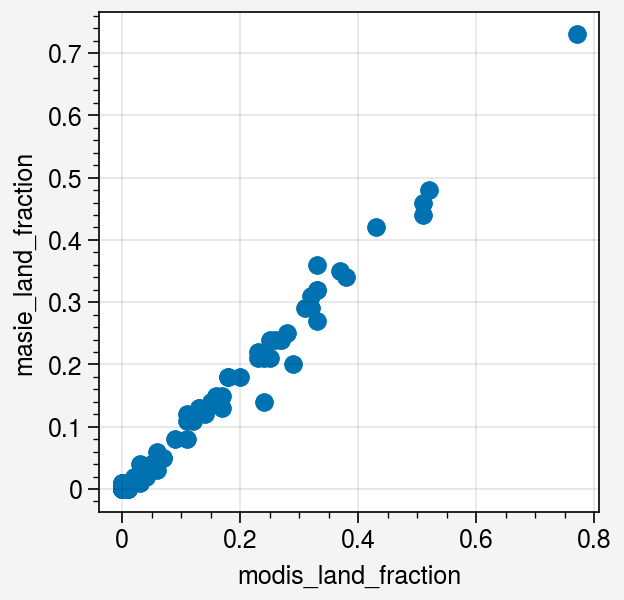

In [16]:
import proplot as pplt
fig, ax = pplt.subplots()
ax.scatter(df.modis_land_fraction, df.masie_land_fraction)

# Sea ice fraction comparison
This figure shows the sea ice fraction (area of grid cells with SIC > 15%) for the NSIDC ice concentration data vs. the MASIE data. In both cases, we've adjusted the percentage to account for the land fraction: the sea ice fraction is computed relative to the ocean area, not the image area. Three things stand out:
1. There are a handful of cases with nonzero NSIDC ice concentration and zero from MASIE. We'll look at these in the Worldview imagery.
2. In many cases, the MASIE data is adding variation to the images where NSIDC has 100% sea ice fraction. Since the NSIDC data has 25 km resolution vs. the 4 km MASIE resolution, we expect that the ice edge will be better resolved.
3. There is some weak correlation between MASIE and NSIDC for the ice fraction in between these extremes.

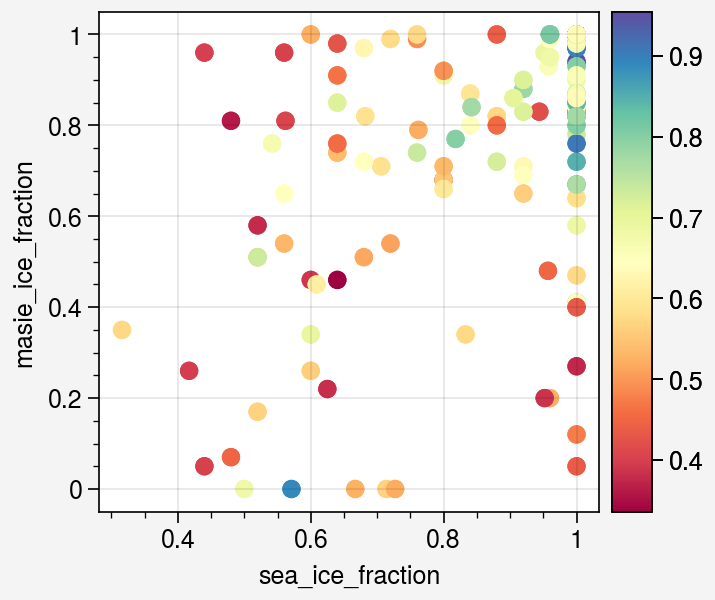

In [73]:
import proplot as pplt
fig, ax = pplt.subplots()
ax.scatter(df.sea_ice_fraction, df.masie_ice_fraction, c=df.mean_sea_ice_concentration, colorbar='r', cmap='spectral')

In [17]:
print('NSIDC > 0, MASIE = 0: ', df.loc[df.masie_ice_fraction == 0].shape[0])
print('MASIE = 1: ', df.loc[df.masie_ice_fraction == 1].shape[0])
print('NSIDC = 1: ', df.loc[df.sea_ice_fraction == 1].shape[0])
print('NSIDC & MASIE = 1:', df.loc[(df.masie_ice_fraction == 1) & (df.sea_ice_fraction == 1)].shape[0])
print('NSIDC = 1 & MASIE != 1:', df.loc[(df.masie_ice_fraction != 1) & (df.sea_ice_fraction == 1)].shape[0])
print('0 < MASIE < 1:', df.loc[(df.masie_ice_fraction > 0) & (df.masie_ice_fraction < 1)].shape[0])
print('0 < NSIDC < 1:', df.loc[(df.sea_ice_fraction > 0) & (df.sea_ice_fraction < 1)].shape[0])

NSIDC > 0, MASIE = 0:  0
MASIE = 1:  142
NSIDC = 1:  224
NSIDC & MASIE = 1: 126
NSIDC = 1 & MASIE != 1: 98
0 < MASIE < 1: 236
0 < NSIDC < 1: 154


In [81]:
df.shape

(378, 26)

In [18]:
df.loc[df.masie_ice_fraction == 0, ['start_date', 'region', 'center_lat', 'center_lon', 'sea_ice_fraction', 'masie_ice_fraction']]

,start_date,region,center_lat,center_lon,sea_ice_fraction,masie_ice_fraction
case_number,,,,,,
